In [17]:
from os import environ
environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/home/valsp/miniconda3/envs/tf/lib"


In [24]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import one_hot
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import KLDivergence
from sklearn import metrics
from model_helper import *
from pathlib import Path

# autoreload
%load_ext autoreload
%autoreload 2


## 1. Load in dataset

In [19]:
cwd = Path().cwd()

In [6]:
with open(cwd.parent / "preprocessing/new_data/training_seq_n_12_rmrp0", "rb") as f:
    train_data = pickle.load(f)
with open(cwd.parent / "preprocessing/new_data/dev_seq_n_12_rmrp0", "rb") as f:
    val_data = pickle.load(f)
with open(cwd.parent / "preprocessing/new_data/test_seq_n_12_rmrp0", "rb") as f:
    test_data = pickle.load(f)

In [7]:
X_train = np.array(train_data["X"])
print(f"X_train shape: {X_train.shape}")
Y_train = np.array(train_data["Y"]).reshape(-1, 1)
print(f"Y_train shape: {Y_train.shape}")
X_val = np.array(val_data["X"])
print(f"X_val shape: {X_val.shape}")
Y_val = np.array(val_data["Y"]).reshape(-1, 1)
print(f"Y_val shape: {Y_val.shape}")
X_test = np.array(test_data["X"])
print(f"X_test shape: {X_test.shape}")
Y_test = np.array(test_data["Y"]).reshape(-1, 1)
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (42598, 12, 22)
Y_train shape: (42598, 1)
X_val shape: (3000, 12, 22)
Y_val shape: (3000, 1)
X_test shape: (3000, 12, 22)
Y_test shape: (3000, 1)


## Load Model

In [8]:
def one_off_accuracy(y_true, y_pred):
    """Computes the accuracy of a grade prediction including +/-1 errors

    Args:
        y_true: true grades
        y_pred: predicted grades
    """
    return tf.reduce_mean(tf.cast(abs(y_true - tf.math.round(y_pred)) <= 1, tf.float32))


In [9]:
GradeNet = load_model("GradeNet", custom_objects={"one_off_accuracy": one_off_accuracy})

## 3. Analyze GradeNet Performance

### Confusion Matrix

In [10]:
# TODO: are these actually the metrics documented in their paper? why are they so shit

In [11]:
REGRESSION = True

In [12]:
Y_train_prob = GradeNet.predict(X_train)
Y_val_prob = GradeNet.predict(X_val)
Y_test_prob = GradeNet.predict(X_test)


94/94 [==============================] - 1s 5ms/step


In [13]:
if not REGRESSION:
    Y_train_pred = Y_train_prob.argmax(axis=1)
    Y_val_pred = Y_val_prob.argmax(axis=1)
    Y_test_pred = Y_test_prob.argmax(axis=1)
else:
    Y_train_pred = np.around(Y_train_prob, 0)
    Y_val_pred = np.around(Y_val_prob, 0)
    Y_test_pred = np.around(Y_test_prob, 0)



In [20]:
Y_test_pred

array([[0.],
       [0.],
       [2.],
       ...,
       [1.],
       [1.],
       [4.]], dtype=float32)

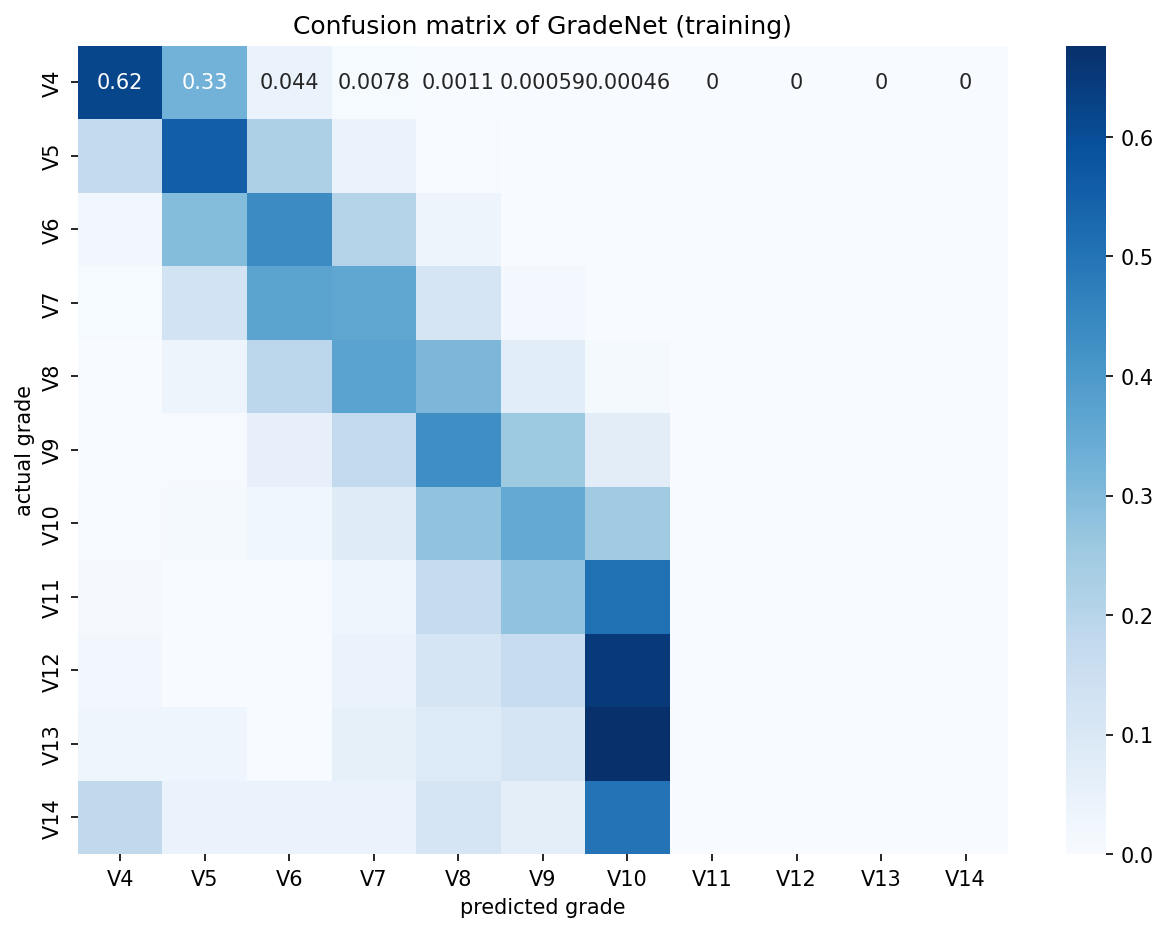

In [26]:
plot_confusion_matrix(Y_train, Y_train_pred, title = 'Confusion matrix of GradeNet (training)')

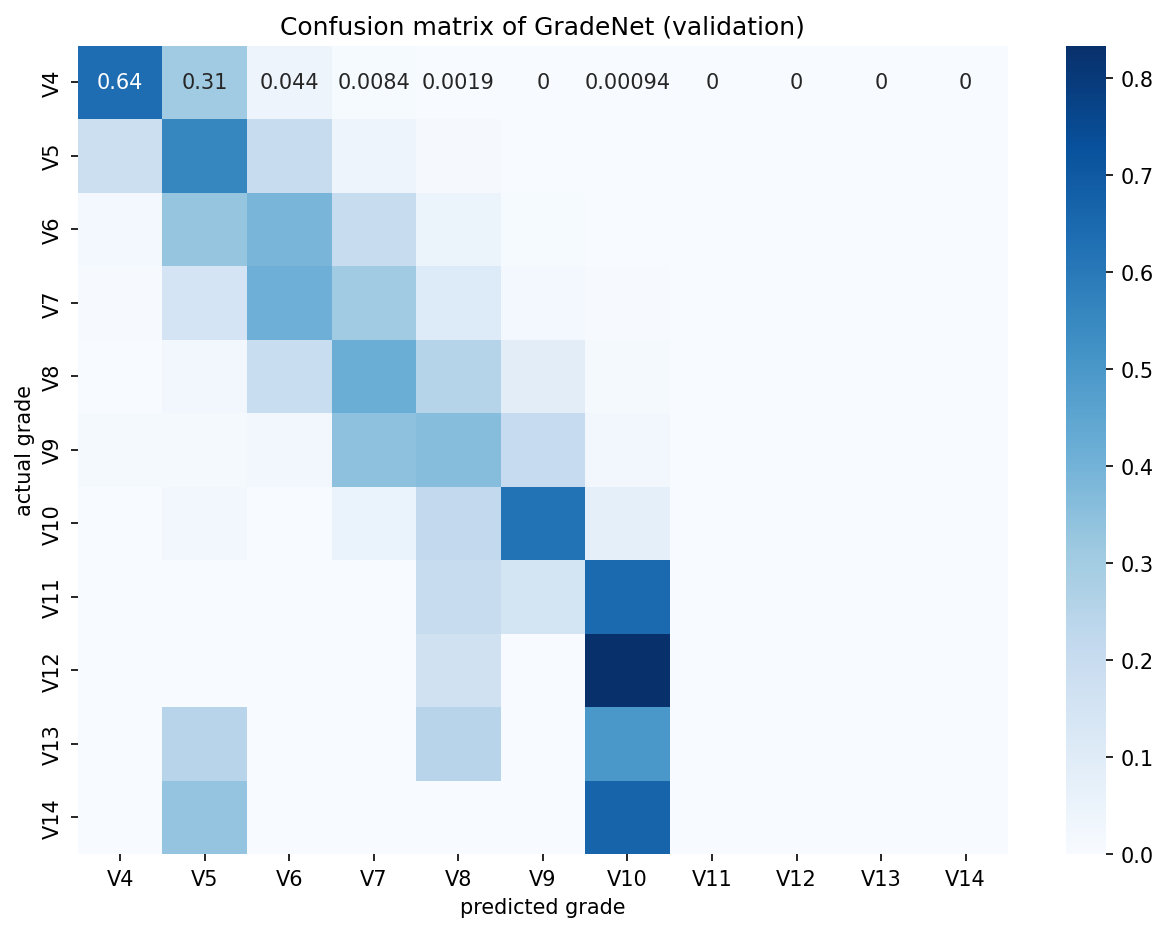

In [27]:
plot_confusion_matrix(Y_val, Y_val_pred, title = 'Confusion matrix of GradeNet (validation)')

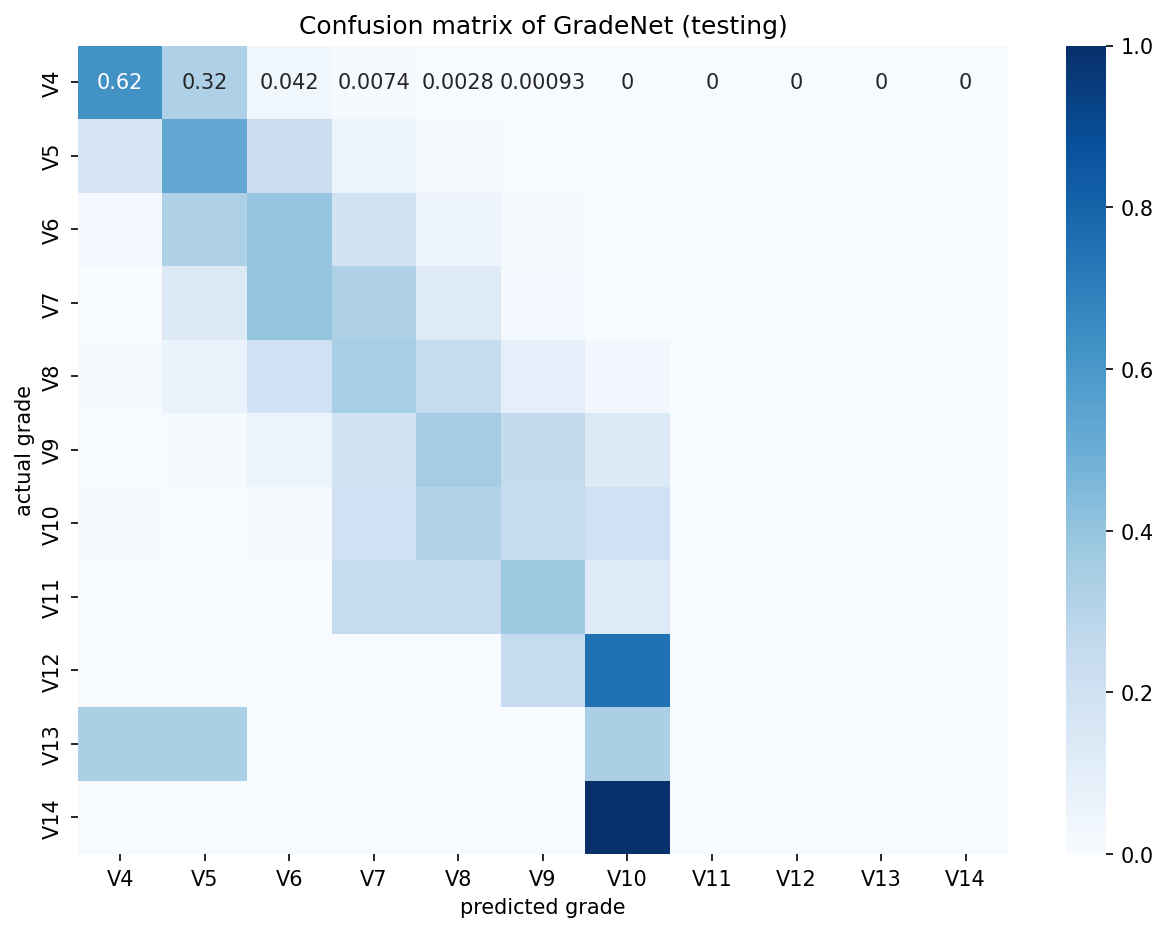

In [28]:
plot_confusion_matrix(Y_test, Y_test_pred, title = 'Confusion matrix of GradeNet (testing)')

### F1 score

In [29]:
F1_train = metrics.f1_score(Y_train, Y_train_pred, average = 'macro')
print(F1_train)

0.2552955167160742


In [30]:
F1_dev = metrics.f1_score(Y_val, Y_val_pred, average = 'macro')
print(F1_dev)

0.2200809150476853


In [31]:
F1_test = metrics.f1_score(Y_test, Y_test_pred, average = 'macro')
print(F1_test)

0.23777561997594795


### Accuracy and Rough accuracy

In [32]:
accuracy_train = compute_accuracy(Y_train, Y_train_pred)
print("Exactly accuracy rate of training set = %s" %accuracy_train[0])
print("+/-1 Accuracy rate of training set= %s" %accuracy_train[1])

Exactly accuracy rate of training set = 0.5069956335978215
+/-1 Accuracy rate of training set= 0.9069439879806563


In [33]:
accuracy_val = compute_accuracy(Y_val, Y_val_pred)
print("Exactly accuracy rate of dev set = %s" %accuracy_val[0])
print("+/-1 Accuracy rate of dev set = %s" %accuracy_val[1])

Exactly accuracy rate of dev set = 0.49566666666666664
+/-1 Accuracy rate of dev set = 0.8976666666666666


In [34]:
accuracy_test = compute_accuracy(Y_test, Y_test_pred)
print("Exactly accuracy rate of test set = %s" %accuracy_test[0])
print("+/-1 Accuracy rate of test set = %s" %accuracy_test[1])

Exactly accuracy rate of test set = 0.48433333333333334
+/-1 Accuracy rate of test set = 0.886


### RMSE

In [35]:
# 
rmse_train = np.sqrt(np.mean((Y_train-Y_train_pred)**2))
print(rmse_train)

rmse_val = np.sqrt(np.mean((Y_val-Y_val_pred)**2))
print(rmse_val)

rmse_test = np.sqrt(np.mean((Y_test-Y_test_pred)**2))
print(rmse_test)

0.9562474194417833
0.9912954487269003
1.0347302385968367


### Classification report

In [36]:
sk_report_train = metrics.classification_report(
    digits=4,
    y_true=Y_train, 
    y_pred=Y_train_pred)
print(sk_report_train)

sk_report_val = metrics.classification_report(
    digits=4,
    y_true=Y_val, 
    y_pred=Y_val_pred)
print(sk_report_val)

sk_report_test = metrics.classification_report(
    digits=4,
    y_true=Y_test, 
    y_pred=Y_test_pred)
print(sk_report_test)

              precision    recall  f1-score   support

         0.0     0.8058    0.6204    0.7011     15210
         1.0     0.4865    0.5539    0.5180     12290
         2.0     0.2948    0.4368    0.3520      5382
         3.0     0.2765    0.3623    0.3137      3704
         4.0     0.4583    0.3110    0.3705      3888
         5.0     0.3333    0.2546    0.2887      1245
         6.0     0.2815    0.2491    0.2643       538
         7.0     0.0000    0.0000    0.0000       220
         8.0     0.0000    0.0000    0.0000        43
         9.0     0.0000    0.0000    0.0000        34
        10.0     0.0000    0.0000    0.0000        44

    accuracy                         0.5070     42598
   macro avg     0.2670    0.2535    0.2553     42598
weighted avg     0.5445    0.5070    0.5171     42598

              precision    recall  f1-score   support

         0.0     0.7951    0.6364    0.7069      1067
         1.0     0.4975    0.5583    0.5261       892
         2.0     0.2768 

/usr/local/Caskroom/miniconda/base/envs/cs137/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniconda/base/envs/cs137/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniconda/base/envs/cs137/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [37]:
if not REGRESSION:
    AUC_train = metrics.roc_auc_score(Y_train, Y_train_prob, multi_class= 'ovr', average="macro")
    print(AUC_train)

    AUC_val = metrics.roc_auc_score(Y_val, Y_val_prob, multi_class= 'ovr', average="macro")
    print(AUC_val)

    AUC_test = metrics.roc_auc_score(Y_test, Y_test_prob, multi_class= 'ovr', average="macro")
    print(AUC_test)